# Report

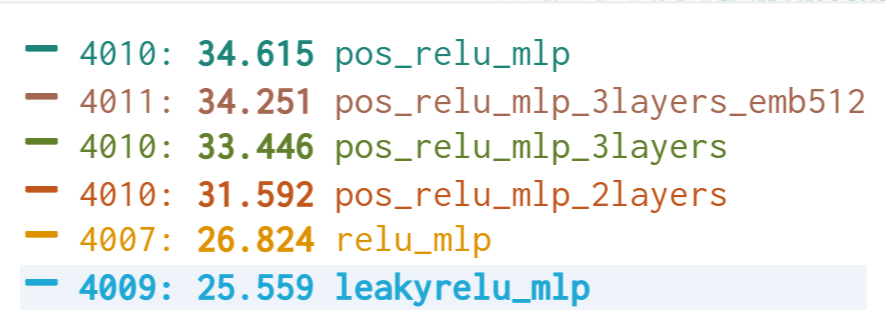

In [ ]:
import plotly.express as px

df = px.data.gapminder().query("year==2007 and continent=='Americas'")

fig = px.scatter(df, x="gdpPercap", y="lifeExp", text="country", log_x=True, size_max=60)

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text='GDP and Life Expectancy (Americas, 2007)'
)

fig.show()

# Code

In [1]:
! nvidia-smi

Thu Feb  9 11:53:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |  10035MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Setup

In [2]:
device = 'cuda:1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../..')

In [5]:
import lovely_tensors as lt # ! pip install lovely-tensors
lt.monkey_patch()

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from IPython.display import display, clear_output

In [7]:
try:
    from prettytable import PrettyTable
except:
    ! pip install prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [8]:
from pathlib import Path
DATA_DIR = Path('../../data')

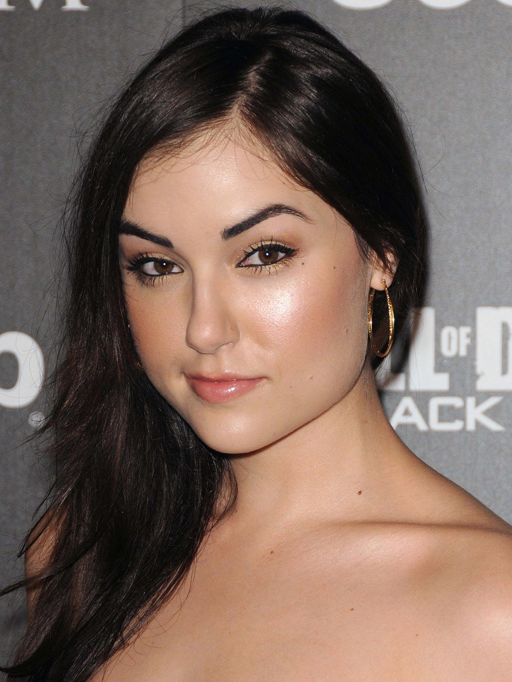

In [9]:
image_pil = Image.open(DATA_DIR/'sasha.jpg')

W, H = image_pil.size
aspect = H/W

W = 512
H = int( W * aspect )
image_pil = image_pil.resize((W,H))

image_pil

In [10]:
image = torch.tensor(np.asarray(image_pil)).permute(2,0,1)/255
H, W = image.shape[1:]
image = image.to(device)
image

tensor[3, 682, 512] n=1047552 x∈[0., 1.000] μ=0.422 σ=0.256 cuda:1

In [11]:
def get_uvs(H, W, device='cpu'):
    xs = torch.linspace(-1, 1, W).to(device)
    ys = torch.linspace(-1, 1, H).to(device)

    x, y = torch.meshgrid(xs, ys, indexing='xy')
    uvs = torch.stack([x,y], dim=-1)
    return uvs

In [12]:
uvs = get_uvs(H, W, device='cpu').to(device)
uvs

tensor[682, 512, 2] n=698368 x∈[-1.000, 1.000] μ=-4.545e-09 σ=0.578 cuda:1

In [13]:
def my_mse_loss(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


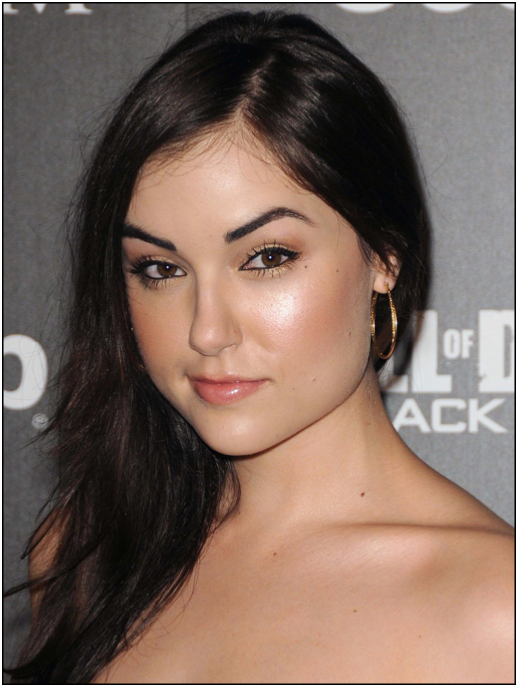

In [14]:
F.grid_sample(image[None], uvs[None]).rgb

In [15]:
def tensor2pil(t): 
    return Image.fromarray((t.detach().permute(1,2,0).clip(0, 1).cpu().numpy() * 255).astype(np.uint8))

In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

## ReLU

In [30]:
class ReluMLP(nn.Module):
    def __init__(self, layer_dims=(2,256,256,3)):
        super().__init__()

        layers = []
        
        for in_dim, out_dim in zip(layer_dims, layer_dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
        
        self.net = nn.Sequential(*layers[:-1])
        
        
    def forward(self, x):
        return self.net(x)

In [48]:
mlp_relu = ReluMLP((2,256,256,256,256,3))
count_parameters(mlp_relu)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    512     |
|  net.0.bias  |    256     |
| net.2.weight |   65536    |
|  net.2.bias  |    256     |
| net.4.weight |   65536    |
|  net.4.bias  |    256     |
| net.6.weight |   65536    |
|  net.6.bias  |    256     |
| net.8.weight |    768     |
|  net.8.bias  |     3      |
+--------------+------------+
Total Trainable Params: 198915


198915

In [ ]:
model = mlp_relu
model.to(device);

In [ ]:
# ! pip install --upgrade wandb

In [ ]:
steps_til_summary = 20
steps_til_vis = 2000
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

import wandb
wandb.init(project='my-neural-fields', name='relu_mlp')

In [ ]:
step_i = 0

while True:
    pred_image = model(uvs)
    pred_image = pred_image.permute(2,0,1)
    mse, psnr = my_mse_loss(pred_image, image)
    
    loss = mse
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'psnr': psnr.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f} psnr={psnr:.4f}')
        display(pred_image.rgb)
        
    step_i += 1

## LeakyReLU

In [ ]:
class LeakyReluMLP(nn.Module):
    def __init__(self, layer_dims=(2,256,256,3)):
        super().__init__()

        layers = []
        
        for in_dim, out_dim in zip(layer_dims, layer_dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.1))
        
        self.net = nn.Sequential(*layers[:-1])
        
        
    def forward(self, x):
        return self.net(x)

In [ ]:
mlp_relu = LeakyReluMLP((2,256,256,256,256,3))
count_parameters(mlp_relu)

In [ ]:
model = mlp_relu
model.to(device);

In [ ]:
# ! pip install --upgrade wandb

In [ ]:
steps_til_summary = 200
steps_til_vis = 2000
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

import wandb
wandb.init(project='my-neural-fields', name='leakyrelu_mlp')

In [ ]:
step_i = 0

while True:
    pred_image = model(uvs)
    pred_image = pred_image.permute(2,0,1)
    mse, psnr = my_mse_loss(pred_image, image)
    
    loss = mse
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'psnr': psnr.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f} psnr={psnr:.4f}')
        display(pred_image.rgb)
        
    step_i += 1

# ReLU with positional embeddings

In [39]:
d = 128

c = torch.pow(1000, torch.linspace(0, 1, d))
c = c.to(device)

def pos_embed(x):
    in_shape = x.shape

    out_shape = (*in_shape[:-1], in_shape[-1]*d)
    return (x.flatten()[:,None]@c[None]).reshape(out_shape).sin()

In [70]:
mlp_relu = ReluMLP((256,256,256,3))
count_parameters(mlp_relu)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |   65536    |
|  net.0.bias  |    256     |
| net.2.weight |   65536    |
|  net.2.bias  |    256     |
| net.4.weight |    768     |
|  net.4.bias  |     3      |
+--------------+------------+
Total Trainable Params: 132355


132355

In [44]:
model = mlp_relu
model.to(device);

In [ ]:
# ! pip install --upgrade wandb

In [45]:
steps_til_summary = 200
steps_til_vis = 2000
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

import wandb
wandb.init(project='my-neural-fields', name='pos_relu_mlp')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


In [46]:
uvs_pos = pos_embed(uvs)
uvs_pos

tensor[682, 512, 256] n=89391104 x∈[-1.000, 1.000] μ=-7.822e-09 σ=0.705 cuda:1

step_i=5000 0.0003 psnr=35.9668


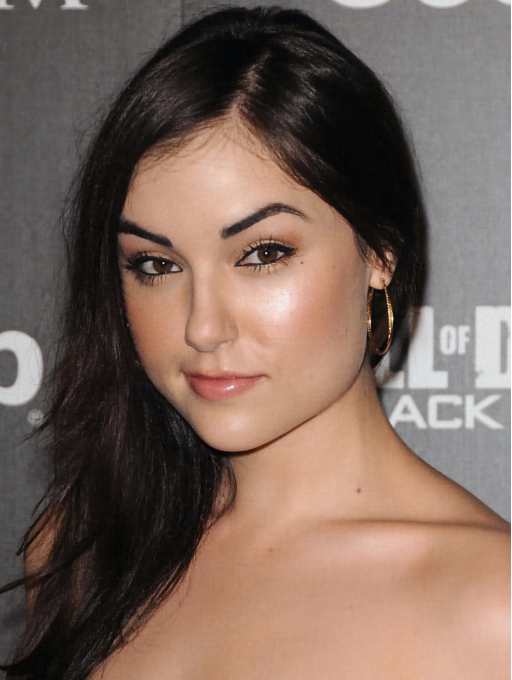

KeyboardInterrupt: 

In [47]:
step_i = 0

while True:
    pred_image = model(uvs_pos)
    pred_image = pred_image.permute(2,0,1)
    mse, psnr = my_mse_loss(pred_image, image)
    
    loss = mse
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'psnr': psnr.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f} psnr={psnr:.4f}')
        display(pred_image.rgb)
        
    step_i += 1

# Smaller pos_mlp

In [31]:
d = 128

c = torch.pow(10_000, torch.linspace(0, 1, d))
c = c.to(device)

def pos_embed(x):
    in_shape = x.shape

    out_shape = (*in_shape[:-1], in_shape[-1]*d)
    return (x.flatten()[:,None]@c[None]).reshape(out_shape).sin()

In [38]:
mlp_relu = ReluMLP((256,256,256,3))
count_parameters(mlp_relu)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |   65536    |
|  net.0.bias  |    256     |
| net.2.weight |   65536    |
|  net.2.bias  |    256     |
| net.4.weight |    768     |
|  net.4.bias  |     3      |
+--------------+------------+
Total Trainable Params: 132355


132355

In [39]:
model = mlp_relu
model.to(device);

In [40]:
# ! pip install --upgrade wandb

In [41]:
steps_til_summary = 200
steps_til_vis = 2000
optimizer = torch.optim.Adam(lr=5e-4, params=model.parameters())

import wandb
wandb.init(project='my-neural-fields', name='pos_relu_mlp_3layers_e10k_smaller_lr')

loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
psnr,▁▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,0.00294
psnr,25.32341
step,1164


In [42]:
uvs_pos = pos_embed(uvs)
uvs_pos

tensor[682, 512, 256] n=89391104 x∈[-1.000, 1.000] μ=1.760e-08 σ=0.705 cuda:1

step_i=16000 0.0003 psnr=34.8659


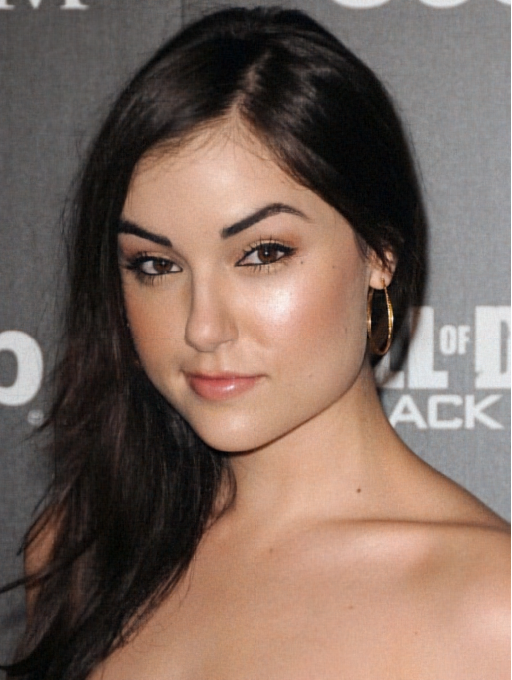

In [ ]:
step_i = 0

while True:
    pred_image = model(uvs_pos)
    pred_image = pred_image.permute(2,0,1)
    mse, psnr = my_mse_loss(pred_image, image)
    
    loss = mse
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'psnr': psnr.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f} psnr={psnr:.4f}')
        display(pred_image.rgb)
        
    step_i += 1

# siren

In [17]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [18]:
siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
count_parameters(siren)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.weight |   65536    |
|  net.2.linear.bias  |    256     |
| net.3.linear.weight |   65536    |
|  net.3.linear.bias  |    256     |
|     net.4.weight    |    768     |
|      net.4.bias     |     3      |
+---------------------+------------+
Total Trainable Params: 198915


198915

In [19]:
model = siren
model.to(device);

In [20]:
# ! pip install --upgrade wandb

In [21]:
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [22]:
steps_til_summary = 200
steps_til_vis = 2000

import wandb
wandb.init(project='my-neural-fields', name='siren')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


step_i=6400 0.0001 psnr=38.3991


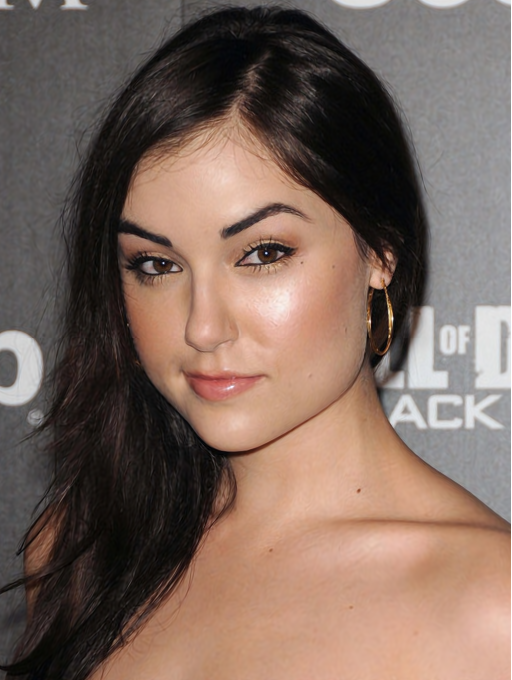

KeyboardInterrupt: 

In [26]:
step_i = 0

while True:
    pred_image = model(uvs)
    pred_image = pred_image.permute(2,0,1)
    mse, psnr = my_mse_loss(pred_image, image)
    
    loss = mse
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'psnr': psnr.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f} psnr={psnr:.4f}')
        display(pred_image.rgb)
        
    step_i += 1

# uinet 

In [ ]:
x = torch.rand(32, 2)

In [ ]:


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc


In [ ]:
# ! pip install random-fourier-features-pytorch
import rff

X = torch.randn((256, 256, 2))
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=64).to(device)
# Xp = encoding(X)
# Xp

In [ ]:
encoding(uvs)

In [ ]:
h = 32

In [ ]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        
    def forward(self, x):
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o

In [ ]:
h = 64

In [ ]:
uber_inet = nn.Sequential(
    encoding,
    UberLayer(128, h),
    UberLayer(h, h),
    UberLayer(h, h),

    nn.Linear(h, 3)
).to(device)

count_parameters(uber_inet)

In [ ]:
steps_til_summary = 20
steps_til_vis = 500
optimizer = torch.optim.Adam(lr=1e-4, params=uber_inet.parameters())

import wandb
wandb.init(project='my-neural-fields', name='uber_inet_00')

count_parameters(uber_inet)

In [ ]:
step_i = 0

while True:
    pred_image = uber_inet(uvs)
    pred_image = pred_image.permute(2,0,1)
    loss = F.mse_loss(pred_image, image)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f}')
        display(pred_image.rgb)
        
    step_i += 1